In [1]:
import pandas as pd

from fwi_predict.constants import WQ_RANGES
from fwi_predict.wq import get_in_required_range

In [2]:
# Load data and remove columns that we don't want for training
predict_df = pd.read_csv("../data/predict_dfs/train/measurements_with_metadata_predict_df.csv")

predict_df = predict_df.drop(columns=['sample_idx', 'pond_id', 'region',
                                      'farm_id', 'sample_dt', 'geometry'])

# Get parameters for classification problem
predict_df['time_of_day'] = predict_df['morning'].apply(lambda x: 'morning' if x else 'evening')
for param in WQ_RANGES.keys():
  range_name = param.split('_')[0] + '_in_range'
  predict_df[range_name] = get_in_required_range(param, predict_df[param], predict_df['time_of_day'])

predict_df = predict_df.drop(columns='time_of_day')
classify_df = predict_df.loc[:, ~predict_df.columns.isin(WQ_RANGES.keys())]
regress_df = predict_df[predict_df.columns[~predict_df.columns.str.endswith('_in_range')].tolist()]

target_columns = ['do_in_range', 'ph_in_range', 'ammonia_in_range', 'turbidity_in_range']  # Replace with actual target column names

In [3]:
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split


# Remove other target columns that we don't want to use for training
target_cols = [col for col in classify_df.columns if col.endswith('_in_range') and col != 'do_in_range']
train_features = classify_df.drop(columns=target_cols)

# Split data into train/test, stratifying on do_in_range label
train_data, _ = train_test_split(train_features, train_size=0.8, random_state=42, stratify=train_features['do_in_range'])
test_data = train_features.drop(train_data.index)

# Initialize predictor for binary classification
predictor = TabularPredictor(
    label='do_in_range',
    problem_type='multiclass',
    eval_metric='accuracy',
    path="../models/autogluon_do_in_range"
)

# Train model
predictor.fit(
    train_data=train_data,
    time_limit=3600,
    presets='high_quality'
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
Memory Avail:       13.84 GB / 31.35 GB (44.1%)
Disk Space Avail:   34.86 GB / 471.56 GB (7.4%)
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and 

In [5]:
# Get model performance
print("Model performance on test data:")
print(predictor.evaluate(test_data, auxiliary_metrics=True, detailed_report=True))

Model performance on test data:
{'accuracy': 0.823943661971831, 'balanced_accuracy': 0.37388829157739223, 'mcc': 0.3301436689625082, 'confusion_matrix':            above  below  within
        3      0      0      15
above   0      2      1      32
below   0      4     43      91
within  4      4     24     771, 'classification_report': {'': {'precision': 0.42857142857142855, 'recall': 0.16666666666666666, 'f1-score': 0.24, 'support': 18.0}, 'above': {'precision': 0.2, 'recall': 0.05714285714285714, 'f1-score': 0.08888888888888889, 'support': 35.0}, 'below': {'precision': 0.6323529411764706, 'recall': 0.3115942028985507, 'f1-score': 0.4174757281553398, 'support': 138.0}, 'within': {'precision': 0.8481848184818482, 'recall': 0.9601494396014943, 'f1-score': 0.9007009345794392, 'support': 803.0}, 'accuracy': 0.823943661971831, 'macro avg': {'precision': 0.5272772970574369, 'recall': 0.37388829157739223, 'f1-score': 0.41176638790591696, 'support': 994.0}, 'weighted avg': {'precision': 0.78

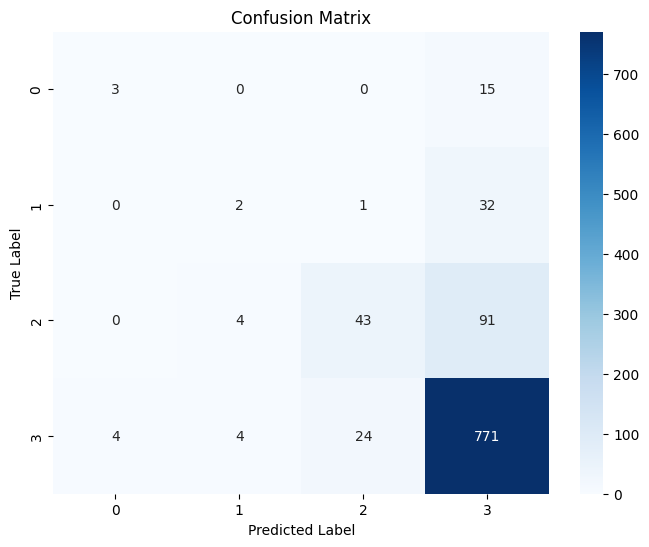


Classification Report:
              precision    recall  f1-score   support

                   0.43      0.17      0.24        18
       above       0.20      0.06      0.09        35
       below       0.63      0.31      0.42       138
      within       0.85      0.96      0.90       803

    accuracy                           0.82       994
   macro avg       0.53      0.37      0.41       994
weighted avg       0.79      0.82      0.79       994



In [7]:
# Model Analysis

# Feature Importances
# feature_importance = predictor.feature_importance(test_data)
# print("\nFeature Importances:")
# print(feature_importance)

# # Learning Curves
# from autogluon.core.metrics import get_metric
# metric = get_metric('accuracy')
# predictor.plot_learning_curves(metric=metric)

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

y_true = test_data['do_in_range']
y_pred = predictor.predict(test_data)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
